In [ ]:
%matplotlib inline

In [ ]:
!pip3 install "nibetaseries==0.6.0"


In [ ]:
!pip install "numpy == 1.18.4"

In [ ]:
!pip3 uninstall numpy -y


Running NiBetaSeries
====================

This example runs through a basic call of NiBetaSeries using
the commandline entry point ``nibs``.
While this example is using python, typically ``nibs`` will be
called directly on the commandline.


Import all the necessary packages
=================================



In [2]:
import tempfile  # make a temporary directory for files
import os  # interact with the filesystem
import urllib.request  # grad data from internet
import tarfile  # extract files from tar
from subprocess import Popen, PIPE, STDOUT  # enable calling commandline

import matplotlib.pyplot as plt  # manipulate figures
import seaborn as sns  # display results
import pandas as pd   # manipulate tabular data
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images

Download relevant data from ds000164 (and Atlas Files)
======================================================
The subject data came from `openneuro
<https://openneuro.org/datasets/ds000164/versions/00001/>`_
:cite:`n-Verstynen2014`.
The atlas data came from a `recently published parcellation
<https://www.ncbi.nlm.nih.gov/pubmed/28981612>`_
in a publically accessible github repository.



In [3]:
# atlas github repo for reference:
"""https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/\
brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/"""
data_dir = tempfile.mkdtemp()
print('Our working directory: {}'.format(data_dir))

# download the tar data
url = "https://www.dropbox.com/s/fvtyld08srwl3x9/ds000164-test_v2.tar.gz?dl=1"

tar_file = os.path.join(data_dir, "ds000164.tar.gz")
u = urllib.request.urlopen(url)
data = u.read()
u.close()

# write tar data to file
with open(tar_file, "wb") as f:
    f.write(data)

# extract the data
tar = tarfile.open(tar_file, mode='r|gz')
tar.extractall(path=data_dir)

os.remove(tar_file)

Our working directory: /tmp/tmpabo1ms7h


Display the minimal dataset necessary to run nibs
=================================================



In [4]:
# https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))


list_files(data_dir)

tmpabo1ms7h/
    ds000164/
        dataset_description.json
        task-stroop_events.json
        task-stroop_bold.json
        T1w.json
        README
        CHANGES
        derivatives/
            fmriprep/
                dataset_description.json
                sub-001/
                    func/
                        sub-001_task-stroop_desc-confounds_regressors.tsv
                        sub-001_task-stroop_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
                        sub-001_task-stroop_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
            data/
                Schaefer2018_100Parcels_7Networks_order.txt
                Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
        sub-001/
            anat/
                sub-001_T1w.nii.gz
            func/
                sub-001_task-stroop_bold.nii.gz
                sub-001_task-stroop_events.tsv


Manipulate events file so it satifies assumptions
=================================================
1. the correct column has 1's and 0's corresponding to correct and incorrect,
respectively.
2. the condition column is renamed to trial_type
nibs currently depends on the "correct" column being binary
and the "trial_type" column to contain the trial types of interest.



read the file
-------------



In [5]:
events_file = os.path.join(data_dir,
                           "ds000164",
                           "sub-001",
                           "func",
                           "sub-001_task-stroop_events.tsv")
events_df = pd.read_csv(events_file, sep='\t', na_values="n/a")
print(events_df.head())

    onset  duration correct  condition  response_time
0   0.342         1       Y    neutral          1.186
1   3.345         1       Y  congruent          0.667
2  12.346         1       Y  congruent          0.614
3  15.349         1       Y    neutral          0.696
4  18.350         1       Y    neutral          0.752


replace condition with trial_type
---------------------------------



In [6]:
events_df.rename({"condition": "trial_type"}, axis='columns', inplace=True)
print(events_df.head())

    onset  duration correct trial_type  response_time
0   0.342         1       Y    neutral          1.186
1   3.345         1       Y  congruent          0.667
2  12.346         1       Y  congruent          0.614
3  15.349         1       Y    neutral          0.696
4  18.350         1       Y    neutral          0.752


save the file
-------------



In [7]:
events_df.to_csv(events_file, sep="\t", na_rep="n/a", index=False)

Manipulate the region order file
================================
There are several adjustments to the atlas file that need to be completed
before we can pass it into nibs.
Importantly, the relevant column names **MUST** be named "index" and "regions".
"index" refers to which integer within the file corresponds to which region
in the atlas nifti file.
"regions" refers the name of each region in the atlas nifti file.



read the atlas file
-------------------



In [8]:
atlas_txt = os.path.join(data_dir,
                         "ds000164",
                         "derivatives",
                         "data",
                         "Schaefer2018_100Parcels_7Networks_order.txt")
atlas_df = pd.read_csv(atlas_txt, sep="\t", header=None)
print(atlas_df.head())

   0                   1    2   3    4  5
0  1  7Networks_LH_Vis_1  120  18  131  0
1  2  7Networks_LH_Vis_2  120  18  132  0
2  3  7Networks_LH_Vis_3  120  18  133  0
3  4  7Networks_LH_Vis_4  120  18  135  0
4  5  7Networks_LH_Vis_5  120  18  136  0


drop color coding columns
-------------------------



In [9]:
atlas_df.drop([2, 3, 4, 5], axis='columns', inplace=True)
print(atlas_df.head())

   0                   1
0  1  7Networks_LH_Vis_1
1  2  7Networks_LH_Vis_2
2  3  7Networks_LH_Vis_3
3  4  7Networks_LH_Vis_4
4  5  7Networks_LH_Vis_5


rename columns with the approved headings: "index" and "regions"
----------------------------------------------------------------



In [10]:
atlas_df.rename({0: 'index', 1: 'regions'}, axis='columns', inplace=True)
print(atlas_df.head())

   index             regions
0      1  7Networks_LH_Vis_1
1      2  7Networks_LH_Vis_2
2      3  7Networks_LH_Vis_3
3      4  7Networks_LH_Vis_4
4      5  7Networks_LH_Vis_5


remove prefix "7Networks"
-------------------------



In [11]:
atlas_df.replace(regex={'7Networks_(.*)': '\\1'}, inplace=True)
print(atlas_df.head())

   index   regions
0      1  LH_Vis_1
1      2  LH_Vis_2
2      3  LH_Vis_3
3      4  LH_Vis_4
4      5  LH_Vis_5


write out the file as .tsv
--------------------------



In [12]:
atlas_tsv = atlas_txt.replace(".txt", ".tsv")
atlas_df.to_csv(atlas_tsv, sep="\t", index=False)

Run nibs
========
This demonstration mimics how you would use nibs on the command line
If you only wanted the beta maps and not the correlation matrices, do not
include the atlas (-a) and lookup table options (-l)



In [13]:
import subprocess
from subprocess import Popen, PIPE, STDOUT  # enable calling commandline


In [14]:
out_dir = os.path.join(data_dir, "ds000164", "derivatives")
work_dir = os.path.join(out_dir, "work")
atlas_mni_file = os.path.join(data_dir,
                              "ds000164",
                              "derivatives",
                              "data",
                              "Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
cmd = """\
nibs -c WhiteMatter CSF \
--participant-label 001 \
--estimator lsa \
--hrf-model glover \
-w {work_dir} \
-a {atlas_mni_file} \
-l {atlas_tsv} \
{bids_dir} \
fmriprep \
{out_dir} \
participant
""".format(atlas_mni_file=atlas_mni_file,
           atlas_tsv=atlas_tsv,
           bids_dir=os.path.join(data_dir, "ds000164"),
           out_dir=out_dir,
           work_dir=work_dir)

# Since we cannot run bash commands inside this tutorial
# we are printing the actual bash command so you can see it
# in the output
print("The Example Command:\n", cmd)

# call nibs
p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)

while True:
    line = p.stdout.readline()
    if not line:
        break
    print(line)

The Example Command:
 nibs -c WhiteMatter CSF --participant-label 001 --estimator lsa --hrf-model glover -w /tmp/tmpabo1ms7h/ds000164/derivatives/work -a /tmp/tmpabo1ms7h/ds000164/derivatives/data/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz -l /tmp/tmpabo1ms7h/ds000164/derivatives/data/Schaefer2018_100Parcels_7Networks_order.tsv /tmp/tmpabo1ms7h/ds000164 fmriprep /tmp/tmpabo1ms7h/ds000164/derivatives participant

b'200611-15:05:50,81 nipype.utils INFO:\n'
b'\t Running nipype version 1.4.2 (latest: 1.5.0)\n'
b"/home/lily/.local/lib/python3.6/site-packages/bids/layout/models.py:157: UserWarning: Accessing entities as attributes is deprecated as of 0.7. Please use the .entities dictionary instead (i.e., .entities['task'] instead of .task.\n"
b'  % (attr, attr))\n'
b"/home/lily/.local/lib/python3.6/site-packages/bids/layout/models.py:157: UserWarning: Accessing entities as attributes is deprecated as of 0.7. Please use the .entities dictionary instead (i.e., .entities['spa

b'200611-15:06:10,636 nipype.workflow INFO:\n'
b'\t [Job 1] Completed (nibetaseries_participant_wf.single_subject001_wf.ds_betaseries_file).\n'
b'200611-15:06:10,638 nipype.workflow INFO:\n'
b'\t [Job 2] Completed (nibetaseries_participant_wf.single_subject001_wf.censor_volumes).\n'
b'200611-15:06:10,640 nipype.workflow INFO:\n'
b'\t [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 226.69/226.69, Free processors: 32/32.\n'
b'200611-15:06:10,706 nipype.workflow INFO:\n'
b'\t [Node] Setting-up "nibetaseries_participant_wf.single_subject001_wf.check_beta_series_list" in "/tmp/tmpabo1ms7h/ds000164/derivatives/work/NiBetaSeries_work/nibetaseries_participant_wf/single_subject001_wf/925968acad4677cdf87bd74827c135468f16a99e/check_beta_series_list".\n'
b'200611-15:06:10,715 nipype.workflow INFO:\n'
b'\t [Node] Running "check_beta_series_list" ("nipype.interfaces.utility.wrappers.Function")\n'
b'200611-15:06:10,729 nipype.workflow INFO:\n'
b'\t [Node] Finished "nibetaseries_parti

b'200611-15:06:30,657 nipype.workflow INFO:\n'
b'\t [Job 16] Completed (_ds_correlation_fig0).\n'
b'200611-15:06:30,659 nipype.workflow INFO:\n'
b'\t [Job 17] Completed (_ds_correlation_fig1).\n'
b'200611-15:06:30,660 nipype.workflow INFO:\n'
b'\t [Job 18] Completed (_ds_correlation_fig2).\n'
b'200611-15:06:30,661 nipype.workflow INFO:\n'
b'\t [Job 19] Completed (_ds_correlation_matrix0).\n'
b'200611-15:06:30,663 nipype.workflow INFO:\n'
b'\t [Job 20] Completed (_ds_correlation_matrix1).\n'
b'200611-15:06:30,664 nipype.workflow INFO:\n'
b'\t [Job 21] Completed (_ds_correlation_matrix2).\n'
b'200611-15:06:30,667 nipype.workflow INFO:\n'
b'\t [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 226.69/226.69, Free processors: 32/32.\n'
b'200611-15:06:30,738 nipype.workflow INFO:\n'
b'\t [Node] Setting-up "nibetaseries_participant_wf.single_subject001_wf.ds_correlation_fig" in "/tmp/tmpabo1ms7h/ds000164/derivatives/work/NiBetaSeries_work/nibetaseries_participant_wf/single_subj

Observe generated outputs
=========================



In [15]:
list_files(data_dir)

tmpabo1ms7h/
    ds000164/
        dataset_description.json
        task-stroop_events.json
        task-stroop_bold.json
        T1w.json
        README
        CHANGES
        derivatives/
            fmriprep/
                dataset_description.json
                fMRIPrep.sqlite
                sub-001/
                    func/
                        sub-001_task-stroop_desc-confounds_regressors.tsv
                        sub-001_task-stroop_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
                        sub-001_task-stroop_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
            data/
                Schaefer2018_100Parcels_7Networks_order.txt
                Schaefer2018_100Parcels_7Networks_order.tsv
                Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
            work/
                dbcache
                NiBetaSeries_work/
                    nibetaseries_participant_wf/
                        graph1.json
                        

Collect correlation results
===========================



In [16]:
output_path = os.path.join(out_dir, "nibetaseries", "sub-001", "func")
trial_types = ['congruent', 'incongruent', 'neutral']
# filename_template = ('sub-001_task-stroop_space-MNI152NLin2009cAsym_'
#                      'desc-{trial_type}_{suffix}.{ext}')

filename_template = ('sub-001_task-stroop_space-MNI152NLin2009cAsym_'
                     'desc-{trial_type}_{suffix}.{ext}')

pd_dict = {}
for trial_type in trial_types:
    fname = filename_template.format(trial_type=trial_type, suffix='correlation', ext='tsv')
    file_path = os.path.join(output_path, fname)
    pd_dict[trial_type] = pd.read_csv(file_path, sep='\t', na_values="n/a", index_col=0)
# display example matrix
print(pd_dict[trial_type].head())

          LH_Vis_1  LH_Vis_2  LH_Vis_3  LH_Vis_4  LH_Vis_5  LH_Vis_6  \
LH_Vis_1       NaN  0.218441 -0.193264  0.122960  0.284347  0.425336   
LH_Vis_2  0.218441       NaN  0.448418  0.526585  0.534536  0.234280   
LH_Vis_3 -0.193264  0.448418       NaN  0.433505  0.193010 -0.054097   
LH_Vis_4  0.122960  0.526585  0.433505       NaN  0.086387 -0.053358   
LH_Vis_5  0.284347  0.534536  0.193010  0.086387       NaN  0.624164   

          LH_Vis_7  LH_Vis_8  LH_Vis_9  LH_SomMot_1  ...  RH_Default_Temp_1  \
LH_Vis_1  0.629166  0.347698  0.465092     0.700271  ...          -0.467447   
LH_Vis_2  0.639844  0.659352  0.389759     0.344053  ...          -0.102012   
LH_Vis_3  0.055205  0.505267 -0.020612    -0.081670  ...          -0.123051   
LH_Vis_4  0.148364  0.335062  0.209862    -0.139957  ...           0.282268   
LH_Vis_5  0.385814  0.353675 -0.123407     0.372037  ...          -0.510798   

          RH_Default_Temp_2  RH_Default_Temp_3  RH_Default_PFCv_1  \
LH_Vis_1           0.55

Graph the correlation results
=============================



/mnt/chrastil/lab/snlbin/programs/mnt/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


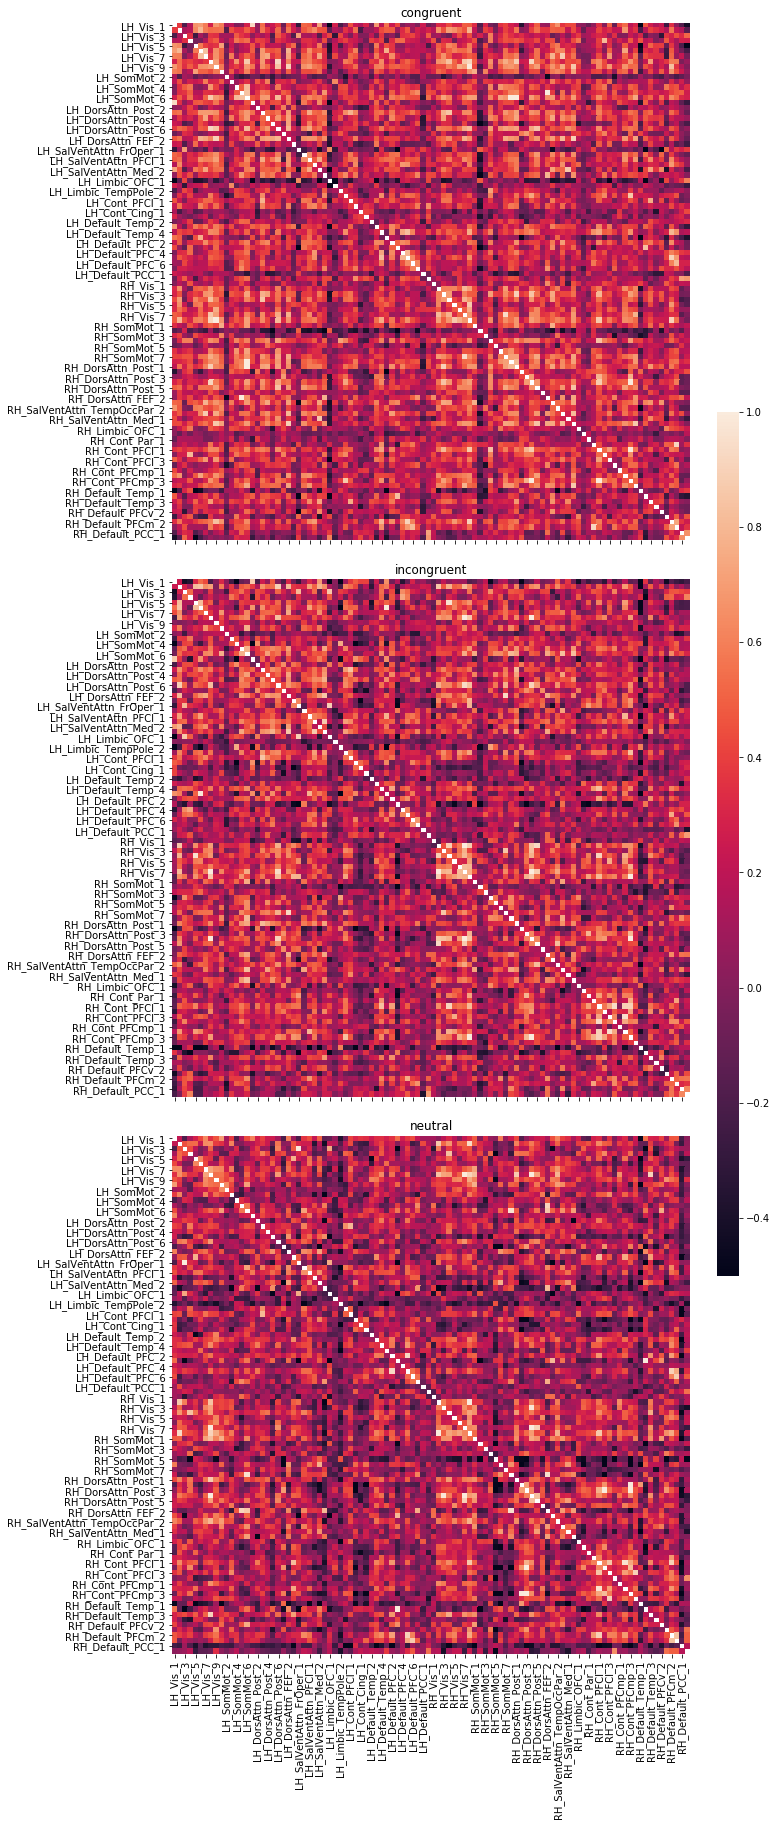

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 30),
                         gridspec_kw={'wspace': 0.025, 'hspace': 0.075})

cbar_ax = fig.add_axes([.91, .3, .03, .4])
r = 0
for trial_type, df in pd_dict.items():
    g = sns.heatmap(df, ax=axes[r], vmin=-.5, vmax=1., square=True,
                    cbar=True, cbar_ax=cbar_ax)
    axes[r].set_title(trial_type)
    # iterate over rows
    r += 1
plt.tight_layout()

Collect beta map results
========================



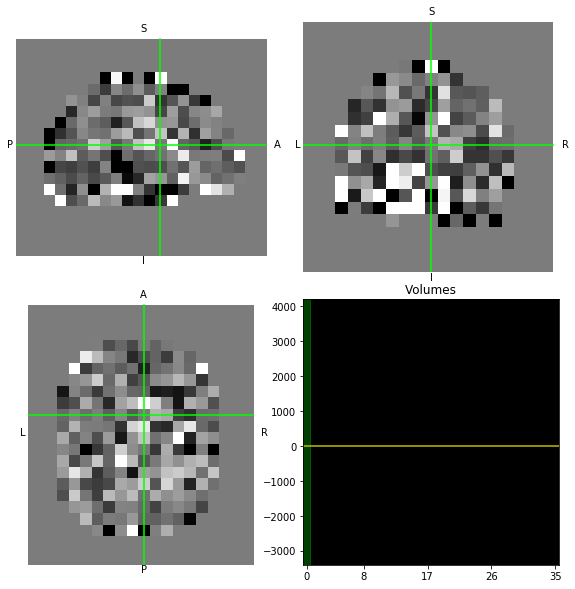

In [18]:
nii_dict = {}
for trial_type in trial_types:
    fname = filename_template.format(trial_type=trial_type, suffix='betaseries', ext='nii.gz')
    file_path = os.path.join(output_path, fname)
    nii_dict[trial_type] = nib.load(file_path)

# view incongruent beta_maps
nib.viewers.OrthoSlicer3D(nii_dict['incongruent'].get_fdata(),
                          title="Incongruent Betas").set_position(10, 13, 10)

Graph beta map standard deviation
=================================
We can find where the betas have the highest standard deviation for each trial type.
Unsuprisingly, the largest deviations are near the edge of the brain mask and
the subcortical regions.



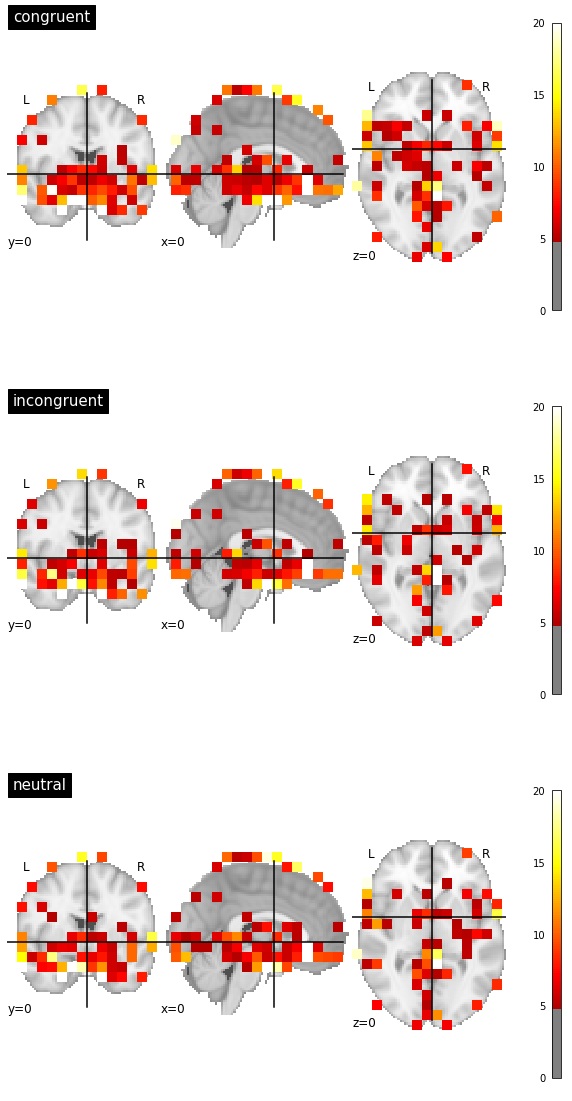

In [19]:
# standard deviations for each trial type
std_dict = {tt: nib.Nifti1Image(img.get_fdata().std(axis=-1), img.affine, img.header)
            for tt, img in nii_dict.items()}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

for idx, (trial_type, nii) in enumerate(std_dict.items()):
    plotting.plot_stat_map(nii, title=trial_type, cut_coords=(0, 0, 0),
                           threshold=5, vmax=20, axes=axes[idx])

### References
==========
.. bibliography:: ../../src/nibetaseries/data/references.bib
   :style: plain
   :labelprefix: notebook-
   :keyprefix: n-


